In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder, scale
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.decomposition import PCA
from sklearn import set_config
set_config(display="diagram")

/Users/sqallihadi/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


https://www.kaggle.com/datasets/joanpau/bike-rentals-study-uci?select=p1_test.csv

![alt text](bike_kaggle.png "Title")

In [3]:
df = pd.read_csv('./datasets/bike_rentals/train.csv',sep=',')
#3 jeux de données -> je prends le fichier 'train.csv' qui semble être le plus large, non traité au préalable

#df = pd.read_csv('./datasets/bike_rentals/p1_train.csv',sep=';')
#df_test = pd.read_csv('./datasets/bike_rentals/p1_test.csv',sep=';')

# 1 - Exploration du Dataset

In [41]:
df.isna().any() # pas de valeurs nulles pour aucune feature du dataset

datetime      False
Year          False
month         False
day           False
hour          False
season        False
holiday       False
workingday    False
weather       False
temp          False
atemp         False
humidity      False
windspeed     False
casual        False
registered    False
rentals       False
dtype: bool

In [5]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [39]:
df.shape

(10886, 16)

In [4]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
# Je transforme la colonne datetime en datetime object
df.datetime = pd.to_datetime(df['datetime'])
# je renomme la feature 'count' en 'rentals' pour éviter la confusion avec la fonction python du mm nom
df = df.rename(columns={'count':'rentals'})

In [6]:
#on créer les colonnes year et hour par insertion (positionnement juste après datetime)
df.insert(1,'Year',df['datetime'].dt.strftime('%Y')) 
df.insert(2,'month',df['datetime'].dt.strftime('%m'))
df.insert(3,'day',df['datetime'].dt.strftime('%d'))
df.insert(4,'hour',df['datetime'].dt.strftime('%H'))

### Graph Barplot - option 1

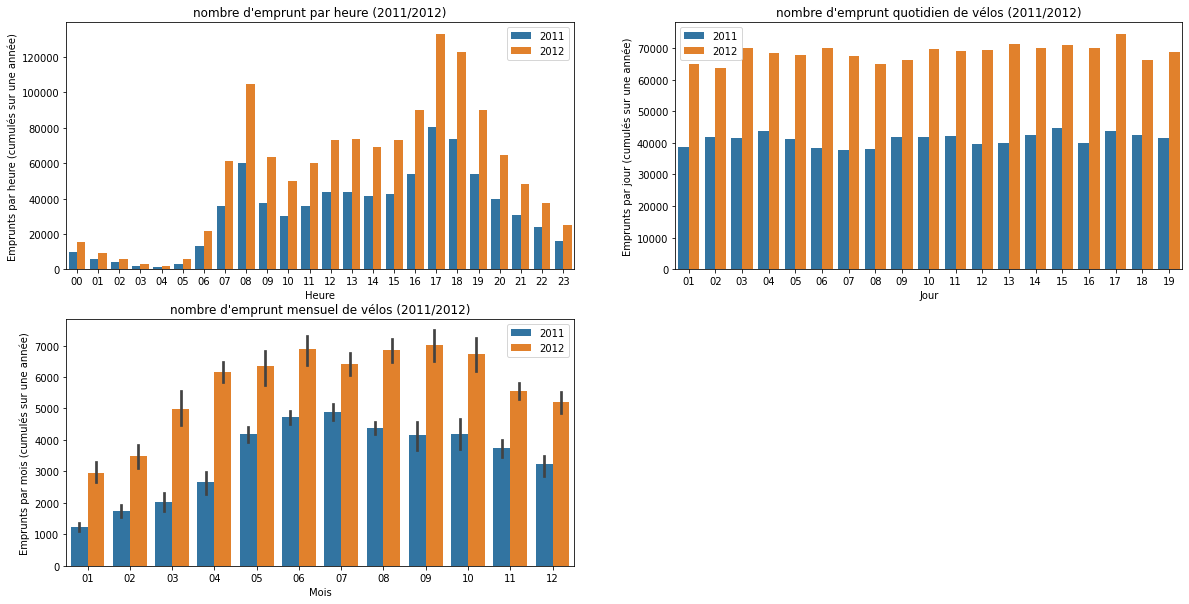

In [10]:
# Méthode un peu barbare pour faire un barplot avec multindex
fig, axs = plt.subplots(2,2,figsize=(20,10))

sns.barplot(x=df.groupby(['Year','day'],axis=0).sum().index.droplevel(0).tolist(),
            y=df.groupby(['Year','day'],axis=0).sum()['rentals'].tolist(),
            hue=df.groupby(['Year','day'],axis=0).sum().index.droplevel(1).tolist(),
            ax=axs[0,1])
axs[0,1].set(xlabel="Jour",ylabel="Emprunts par jour (cumulés sur une année)")
axs[0,1].set_title('nombre d\'emprunt quotidien de vélos (2011/2012)')

sns.barplot(x=df.groupby(['Year','hour'],axis=0).sum().index.droplevel(0).tolist(),
            y=df.groupby(['Year','hour'],axis=0).sum()['rentals'].tolist(),
            hue=df.groupby(['Year','hour'],axis=0).sum().index.droplevel(1).tolist(),
            ax=axs[0,0])
axs[0,0].set(xlabel="Heure",ylabel="Emprunts par heure (cumulés sur une année)")
axs[0,0].set_title('nombre d\'emprunt par heure (2011/2012)')

sns.barplot(x=df.groupby(['Year','month','day'],axis=0).sum().index.droplevel(0).droplevel(1).tolist(),
            y=df.groupby(['Year','month','day'],axis=0).sum()['rentals'].tolist(),
            hue=df.groupby(['Year','month','day'],axis=0).sum().index.droplevel(1).droplevel(1).tolist(),
            ax=axs[1,0])
axs[1,0].set(xlabel="Mois",ylabel="Emprunts par mois (cumulés sur une année)")
axs[1,0].set_title('nombre d\'emprunt mensuel de vélos (2011/2012)')

axs[1,1].hist(df['rentals'],bins=20)
axs[1,1].set_visible(False)

plt.show()


### Graph Barplot - option 2

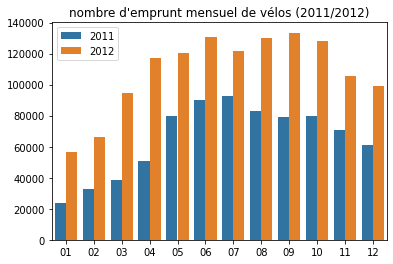

In [11]:
#df.groupby(['Year','month'],axis=0).sum()['rentals']
sns.barplot(x=df.groupby(['Year','month'],axis=0).sum().index.droplevel(0).tolist(),
            y=df.groupby(['Year','month'],axis=0).sum()['rentals'].tolist(),
            hue=df.groupby(['Year','month'],axis=0).sum().index.droplevel(1).tolist())
plt.title('nombre d\'emprunt mensuel de vélos (2011/2012)')
plt.show()

### Graph Barplot - option 3

In [12]:
# on créer le DataFrame 'df_test' qui rassemble la somme des emprunts de vélo réechantillonnés par mois
df_month_resample = df.set_index('datetime').resample('M').sum()['rentals']
df_test = df_month_resample.reset_index()
df_test['year']=df_test['datetime'].dt.strftime('%Y')
df_test['month']=df_test['datetime'].dt.strftime('%m')
df_test.head()

,datetime,rentals,year,month
0,2011-01-31,23552,2011,01
1,2011-02-28,32844,2011,02
2,2011-03-31,38735,2011,03
3,2011-04-30,50517,2011,04
4,2011-05-31,79713,2011,05


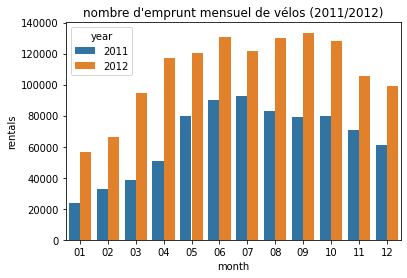

In [13]:
# Barplot du nombre de vélos empruntés par mois et par années
sns.barplot(x=df_test['month'],y=df_test['rentals'],hue=df_test['year'])
plt.xticks()
plt.title('nombre d\'emprunt mensuel de vélos (2011/2012)')
plt.show()

### Scatterplot des emprunts sur les deux années

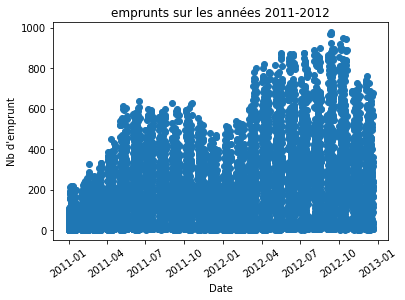

In [15]:
plt.scatter(x=df['datetime'],y=df['rentals'])
plt.title("emprunts sur les années 2011-2012")
plt.xlabel("Date")
plt.ylabel("Nb d'emprunt")
plt.xticks(rotation=35)
plt.show()

## Pairplot

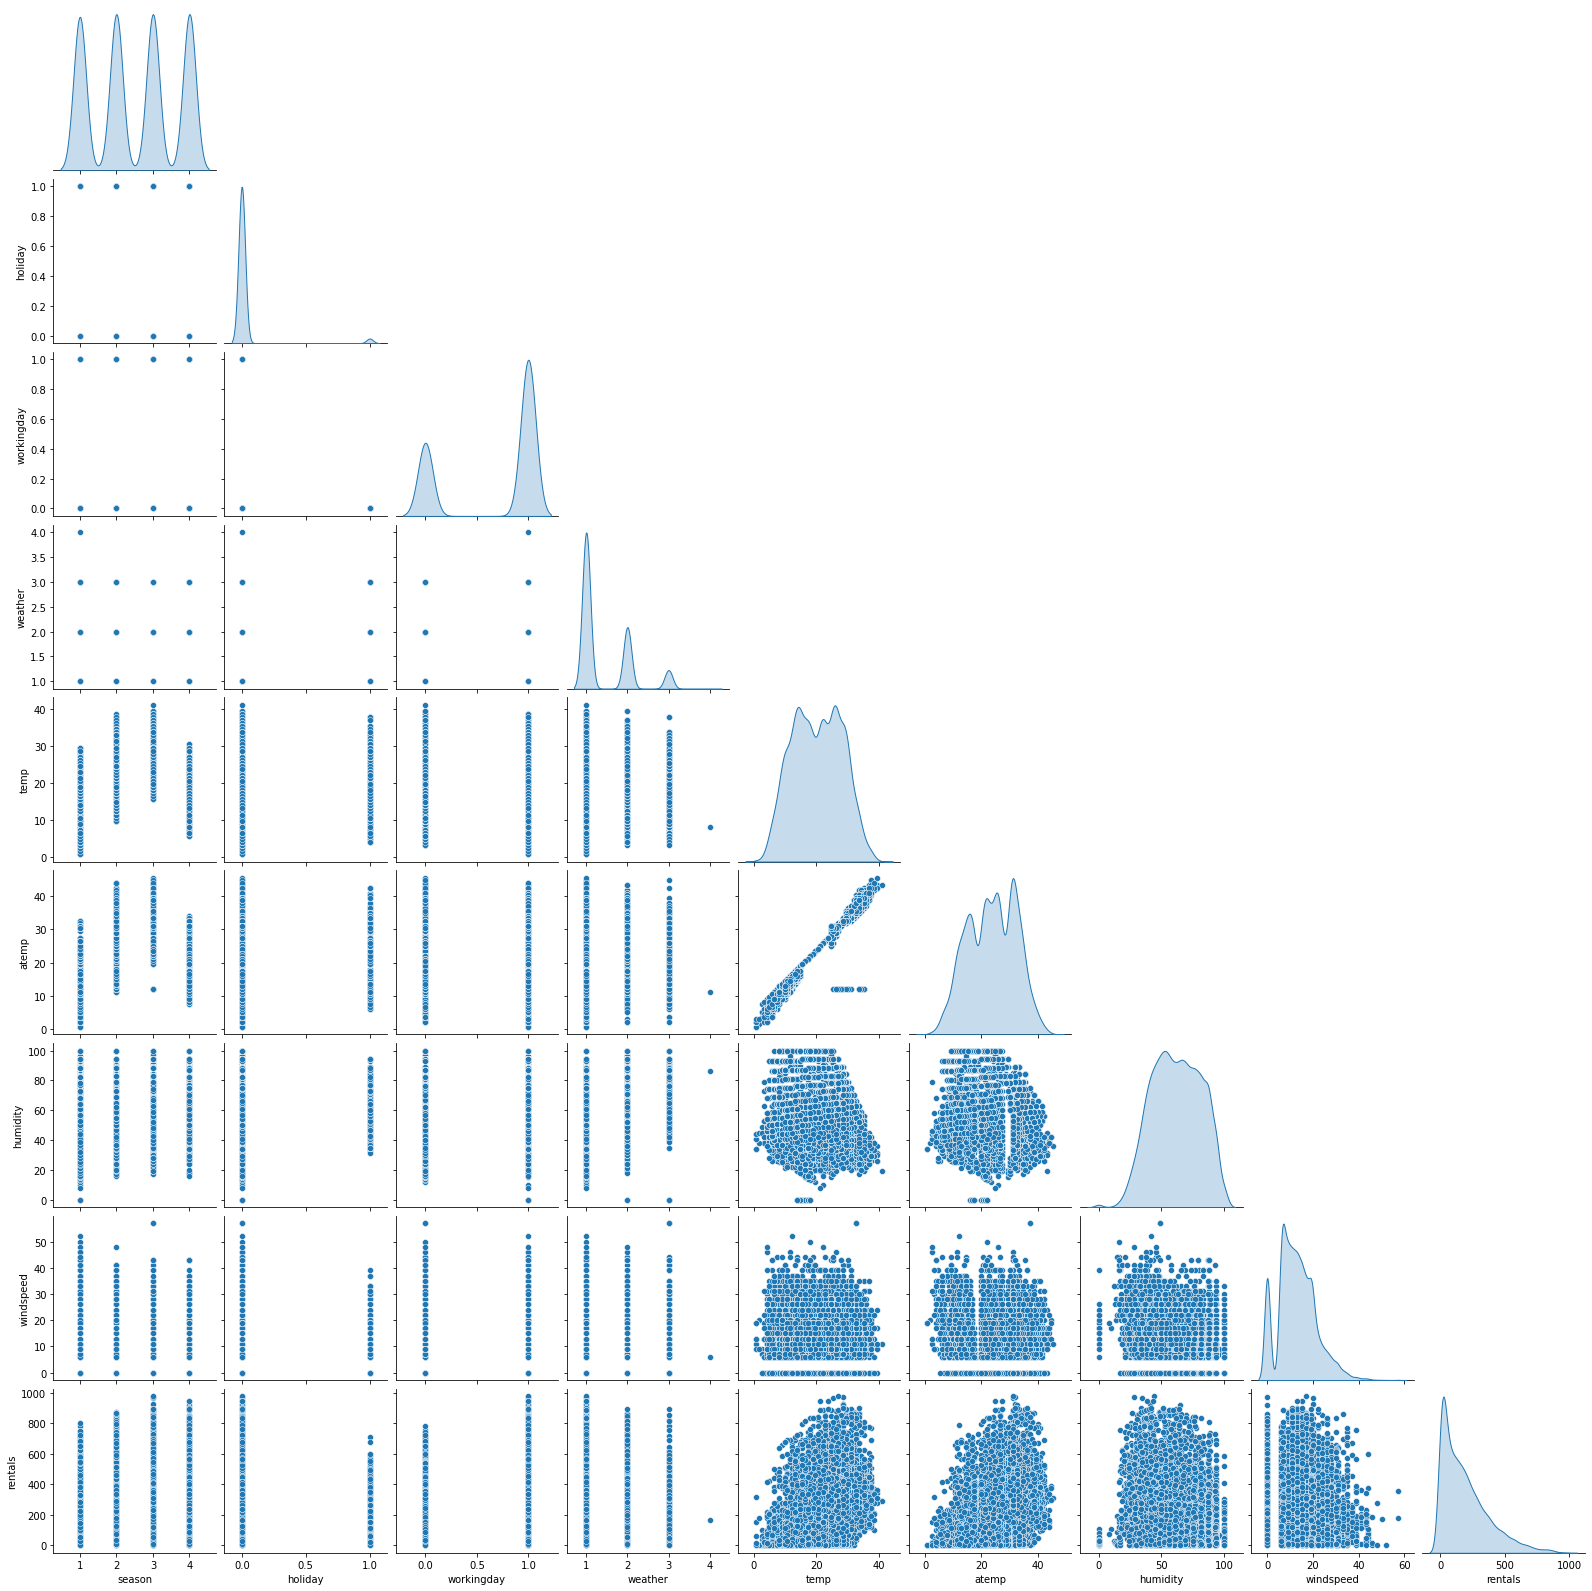

In [40]:
sns.pairplot(df.drop(columns=['casual','registered']),corner=True,diag_kind='kde')
plt.show()

## Heatmap

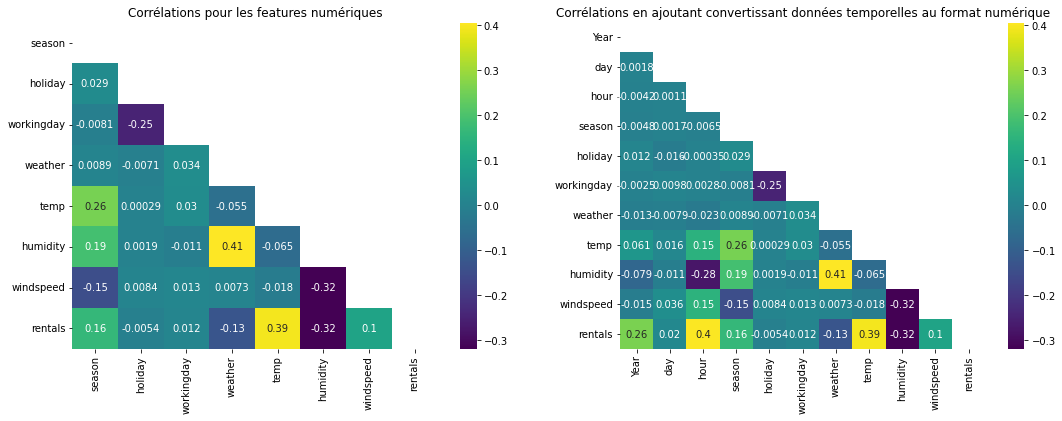

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,6))
sns.heatmap(df.drop(columns=['atemp','casual','registered']).corr(),
            mask=np.triu(df.drop(columns=['atemp','casual','registered']).corr()),
            cmap='viridis',annot=True,ax=ax1)
ax1.set_title('Corrélations pour les features numériques')


dftemp = copy.copy(df)
dftemp[['Year','hour','day','month']] = dftemp[['Year','hour','day','month']].astype('int64')
sns.heatmap(dftemp.drop(columns=['atemp','casual','registered','month']).corr(),
            mask=np.triu(dftemp.drop(columns=['atemp','casual','registered','month']).corr()),
            cmap='viridis',annot=True,ax=ax2)
ax2.set_title('Corrélations en ajoutant convertissant données temporelles au format numérique')


plt.show()

# 2 - Preprocess Pipeline + prédictions

In [18]:
def make_mix_pipeline(scaler=MinMaxScaler(), model=LinearRegression()):
    num_transformer = Pipeline([(f'scaler:{scaler}', scaler)])
    cat_transformer = OneHotEncoder(handle_unknown='ignore')
    numerical_features = make_column_selector(dtype_include = np.number)
    cat_features = make_column_selector(dtype_exclude = np.number)
    preprocessing_transformer = ColumnTransformer([('num columns',num_transformer, numerical_features),('cat columns',cat_transformer, cat_features)])
    pipeline_workflow = Pipeline([('preprocessing_tranformer', preprocessing_transformer),(f'{model}', model)])
    return pipeline_workflow

In [19]:
df.dtypes

datetime      datetime64[ns]
Year                  object
month                 object
day                   object
hour                  object
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
rentals                int64
dtype: object

## 2.1 - Prédiction 1 : MinMax Scaler, Regression linéaire simple

### **Cas 1** : On entraîne le modèle avec les features ['Year', 'month', 'day', 'hour', 'season', 'holiday','workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']
### **--> avec 'Year', 'month', 'day', 'hour' en objets datetime[ns]**

In [20]:
df_relevant = df.drop(columns=['datetime','casual','registered'])
#df_relevant['season'] = df_relevant['season'].astype('category') -> ne change rien, la saison semble peu impacter les performances du modèle

y = df_relevant[['rentals']]
X = df_relevant.drop(columns=['rentals'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=7)

first_pred = make_mix_pipeline() #minmax, reglin
first_pred.fit(X_train, y_train)
first_score = first_pred.score(X_test, y_test)
first_cv = cross_val_score(first_pred, X_train, y_train, cv=5, scoring='r2').mean()
print(f"score de prédiction sur le jeu de test :{first_score}")
print(f"score de cross-validation : {first_cv}")

score de prédiction sur le jeu de test :0.6700327689529435
score de cross-validation : 0.6944336981502196


In [21]:
# vérifions ce qu'il se passe dans le Pipeline
CT = ColumnTransformer([('num columns',Pipeline([('minmax', MinMaxScaler())]),
                         make_column_selector(dtype_include = np.number)),
                        ('cat columns',OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_exclude = np.number))])

tata = CT.fit(X_train)
toto = pd.DataFrame.sparse.from_spmatrix(tata.transform(X_train))
print('taille de la matrice transformée par l\'encodeur et le scaler',toto.shape)
toto.head()

taille de la matrice transformée par l'encodeur et le scaler (7620, 65)


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,0.333333,1.0,0.0,0.0,0.755102,0.745721,0.45,0.423141,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,1.0,0.0,0.122449,0.101689,0.50,0.500064,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.333333,0.0,0.0,0.0,0.653061,0.677928,0.50,0.288494,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.163265,0.152478,0.37,0.538462,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,1.0,0.0,0.183673,0.203378,0.51,0.249968,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **Cas 2** : On entraîne le modèle avec les features ['Year', 'month', 'day', 'hour', 'season', 'holiday','workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']
### **--> avec 'Year', 'month', 'day', 'hour' convertis en valeurs entières (int64)** marche avec **float64**

In [22]:
df_relevant_2 = df.drop(columns=['datetime','casual','registered'])

df_relevant_2[['Year','month','day','hour']] = df_relevant_2[['Year','month','hour','day']].astype('int64')

y_2 = df_relevant_2[['rentals']]
X_2 = df_relevant_2.drop(columns=['rentals'])

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2,y_2, test_size=0.3, random_state=7)

first_pred_2 = make_mix_pipeline()
first_pred_2.fit(X_train_2,y_train_2)
first_score_2 = first_pred_2.score(X_test_2, y_test_2)
first_cv_2 = cross_val_score(first_pred_2, X_train_2, y_train_2, cv=5, scoring='r2').mean()
print(f"score de prédiction sur le jeu de test :{first_score_2}")
print(f"score de cross-validation : {first_cv_2}")

score de prédiction sur le jeu de test :0.3836639748480425
score de cross-validation : 0.38906719796614236


In [23]:
# vérifions ce qu'il se passe dans le Pipeline
CT = ColumnTransformer([('num columns',Pipeline([('minmax', MinMaxScaler())]),
                         make_column_selector(dtype_include = np.number)),
                        ('cat columns',OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_exclude = np.number))])

tata = CT.fit(X_train_2)
toto = pd.DataFrame(tata.transform(X_train_2))
print('taille de la matrice transformée par l\'encodeur et le scaler',toto.shape)
toto.head()

taille de la matrice transformée par l'encodeur et le scaler (7620, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,0.272727,0.608696,0.833333,0.333333,1.0,0.0,0.0,0.755102,0.745721,0.45,0.423141
1,0.0,0.000000,0.260870,0.111111,0.000000,0.0,1.0,0.0,0.122449,0.101689,0.50,0.500064
2,1.0,0.454545,0.652174,0.888889,0.333333,0.0,0.0,0.0,0.653061,0.677928,0.50,0.288494
3,1.0,0.090909,0.739130,0.611111,0.000000,0.0,0.0,0.0,0.163265,0.152478,0.37,0.538462
4,0.0,0.090909,0.173913,0.833333,0.000000,0.0,1.0,0.0,0.183673,0.203378,0.51,0.249968


En convertissant les datetime objects en int64, on a injecté au modèle des valeurs numériques et non catégorielles. Ce qui montre que les datetime objects sont gérés comme des category par l'encodeur et traité en conséquence

### **Cas 3** : On entraîne le modèle avec les features ['Year', 'month', 'day', 'hour', 'season', 'holiday','workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']
### **--> avec 'Year', 'month', 'day', 'hour' en objets catégoriels** (marche avec **string**)

In [24]:
df_relevant_3 = df.drop(columns=['datetime','casual','registered'])

df_relevant_3[['Year','month','day','hour','season']] = df_relevant_3[['Year','month','hour','day','season']].astype('str')

y_3 = df_relevant_3[['rentals']]
X_3 = df_relevant_3.drop(columns=['rentals']) #si on drop season -> le score ne diminue pas. Peu d'impact

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3,y_3, test_size=0.3, random_state=7)

pred_3 = make_mix_pipeline()
pred_3.fit(X_train_3,y_train_3)
score_3 = pred_3.score(X_test_3, y_test_3)
cv_3 = cross_val_score(pred_3, X_train_3, y_train_3, cv=5, scoring='r2').mean()
print(f"score de prédiction sur le jeu de test :{score_3}")
print(f"score de cross-validation : {cv_3}")

score de prédiction sur le jeu de test :0.6700327690053561
score de cross-validation : 0.6944336992425385


In [25]:
tata = CT.fit(X_train_3)
toto = pd.DataFrame.sparse.from_spmatrix(tata.transform(X_train_3))
print('taille de la matrice transformée par l\'encodeur et le scaler',toto.shape)
toto.head()

taille de la matrice transformée par l'encodeur et le scaler (7620, 68)


,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,1.0,0.0,0.0,0.755102,0.745721,0.45,0.423141,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.122449,0.101689,0.50,0.500064,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.653061,0.677928,0.50,0.288494,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.163265,0.152478,0.37,0.538462,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.183673,0.203378,0.51,0.249968,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## 2.2 - Prédiction 2

### ajout d'une feature correspondant à des moments de la journée 'day_moment'

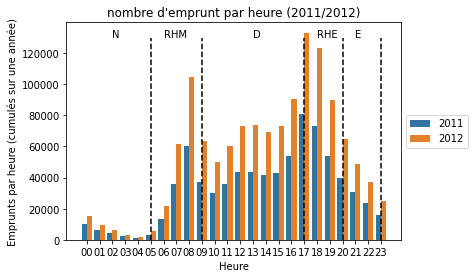

In [26]:
sns.barplot(x=df.groupby(['Year','hour'],axis=0).sum().index.droplevel(0).tolist(),
            y=df.groupby(['Year','hour'],axis=0).sum()['rentals'].tolist(),
            hue=df.groupby(['Year','hour'],axis=0).sum().index.droplevel(1).tolist())

#d = {5:'N',9:'RHM',17:'RHE',23:''}
for i in [5,9,17,20,23]:
    plt.vlines(x=i,ymin=0,ymax=130000,linestyles='dashed',colors='black')

plt.annotate('N',xy=(2,130000))
plt.annotate('RHM',xy=(6,130000))
plt.annotate('D',xy=(13,130000))
plt.annotate('RHE',xy=(18,130000))
plt.annotate('E',xy=(21,130000))


plt.xlabel("Heure")
plt.ylabel("Emprunts par heure (cumulés sur une année)")
plt.title('nombre d\'emprunt par heure (2011/2012)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Mapping sur la colonne 'hour' pour créer une colonne 'day_moment'

In [27]:
# ajout de la feature catégorielle 'daytime' qui va diviser les heures en 5 morceaux : 
# Night/Rush_Hour_morning/Late_morning/RH_afternoon/Evening

def day_moment_mapping(hour):
    if hour in range(7):
        return 'N'
    elif hour in range(6,10):
        return 'RHM'
    elif hour in range(9,18):
        return 'D'
    elif hour in range(17,21):
        return 'RHE'
    else:
        return 'E'

import copy
df_test = copy.copy(df)
df_test['day_moment'] = df_test['hour'].apply(lambda x: day_moment_mapping(x))
#df_test['day_moment'] = df_test['day_moment'].astype('category') -> devrait ne rien changer

### Modèle de Régression linéaire avec minmaxscaler

In [29]:
df_relevant_4 = df_test.drop(columns=['datetime','casual','registered'])

y_4 = df_relevant_4[['rentals']] 
X_4 = df_relevant_4.drop(columns=['rentals'])
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4,y_4, test_size=0.3, random_state=7)

pred_4 = make_mix_pipeline() #minmax, reglin
pred_4.fit(X_train_4, y_train_4)
score_4 = pred_4.score(X_test_4, y_test_4)
cv_4 = cross_val_score(first_pred, X_train_4, y_train_4, cv=5, scoring='r2').mean()
print(f"score de prédiction sur le jeu de test :{score_4}")
print(f"score de cross-validation : {cv_4}")


score de prédiction sur le jeu de test :0.6700327690699017
score de cross-validation : 0.6944336981115086


### **Le score ne change pas** (ce qui semble logique car l'information est redondante avec la feature 'hour' et n'apporte pas d'information nouvelle)

In [30]:
tata = CT.fit(X_train_4)
toto = pd.DataFrame.sparse.from_spmatrix(tata.transform(X_train_4))
print('taille de la matrice transformée par l\'encodeur et le scaler',toto.shape)
toto.head()

taille de la matrice transformée par l'encodeur et le scaler (7620, 66)


,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,0.333333,1.0,0.0,0.0,0.755102,0.745721,0.45,0.423141,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.000000,0.0,1.0,0.0,0.122449,0.101689,0.50,0.500064,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.333333,0.0,0.0,0.0,0.653061,0.677928,0.50,0.288494,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.000000,0.0,0.0,0.0,0.163265,0.152478,0.37,0.538462,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.000000,0.0,1.0,0.0,0.183673,0.203378,0.51,0.249968,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


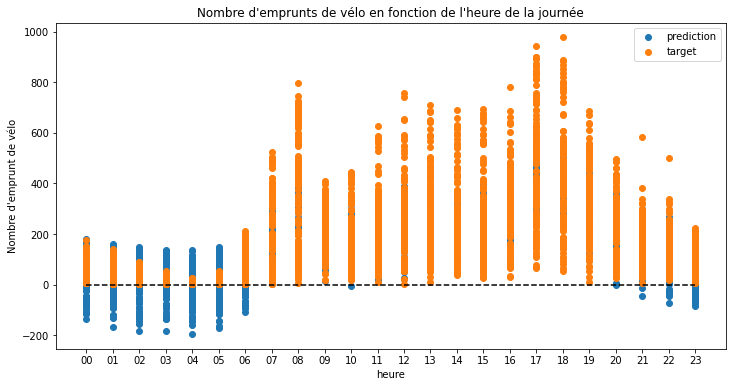

In [42]:
plt.figure(figsize=(12,6))
plt.scatter(X_test_4.sort_values('hour',ascending=True)['hour'],pred_4.predict(X_test_4.sort_values('hour',ascending=True)),label='prediction')
plt.scatter(X_test_4['hour'],y_test_4,label='target')
plt.hlines(y=0,xmin=0,xmax=23,colors='black',linestyles='dashed')
plt.legend()
plt.title('Nombre d\'emprunts de vélo en fonction de l\'heure de la journée')
plt.xlabel('heure')
plt.ylabel('Nombre d\'emprunt de vélo')
plt.show()

### Intéressant : on constate que le modèle prédit un nombre d'emprunt négatif..! Voir comment améliorer ça en lui "interdisant" ce type de prédiciton

In [32]:
X_test_3.dtypes

Year           object
month          object
day            object
hour           object
season         object
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
dtype: object

In [33]:
X_test_3.head(3)

,Year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
3502,2011,08,20,15,3,0,1,1,27.06,31.060,74,8.9981
6462,2012,03,12,06,1,0,1,1,10.66,13.635,41,7.0015
3275,2011,08,09,06,3,0,0,1,30.34,34.850,70,15.0013


## 2.3 - Prédiction 3 (Ridge, Lasso, ElasticNet etc..)

In [48]:
df_relevant_5 = df_test.drop(columns=['datetime','casual','registered'])

y = df_relevant_5[['rentals']] 
X = df_relevant_5.drop(columns=['rentals','Year'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=7)

pred_5 = make_mix_pipeline(model=Ridge(alpha=0.9)) #minmax, reglin
pred_5.fit(X_train, y_train)
score_5 = pred_5.score(X_test, y_test)
cv_5 = cross_val_score(first_pred, X_train_4, y_train_4, cv=5, scoring='r2').mean()
print(f"score de prédiction sur le jeu de test :{score_5}")
print(f"score de cross-validation : {cv_5}")

score de prédiction sur le jeu de test :0.6074877081085428
score de cross-validation : 0.6944336981115086


### Amélioration de 0.2% sur le score en utilisant le Ridge..
### Mêmes ordres de grandeurs en utilisant d'autres leviers : ElasticNet / Lasso / etc..

# Export en Pickle pour créer une API

In [ ]:
import pickle

f = open('bike_rental_model.pkl','wb')
pickle.dump(pred_3,f)

In [ ]:
# Pour les séries temporelles :
# Regarder : 
# ARIMA "Auto-Regressive Integrated Moving Average"
# SARIMAX
# 
# Dans statsmodel : "decompose serie temporelle" qqchose -> checker
# decompose en partie saisonnière, résiduelle
# 

## PCA ?

In [35]:
# first center and scale the data   
scaled_data = scale(df_relevant.drop(columns=['Year','hour']).T)

pca = PCA() # create a PCA object
pca.fit(scaled_data) # do the math
pca_data = pca.transform(scaled_data) # get PCA coordinates for scaled_data

In [36]:
print(df_relevant.drop(columns=['Year','hour']).columns)
print(pca.explained_variance_)

Index(['month', 'day', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'rentals'],
      dtype='object')
[8.79938225e+03 2.89744590e+03 1.16535126e+02 1.11675803e+02
 3.73609063e+01 1.05736998e+01 9.19986076e-01 4.19958627e-01
 2.22256953e-01 6.41097176e-02 2.90452044e-27]


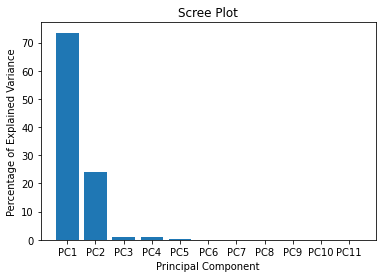

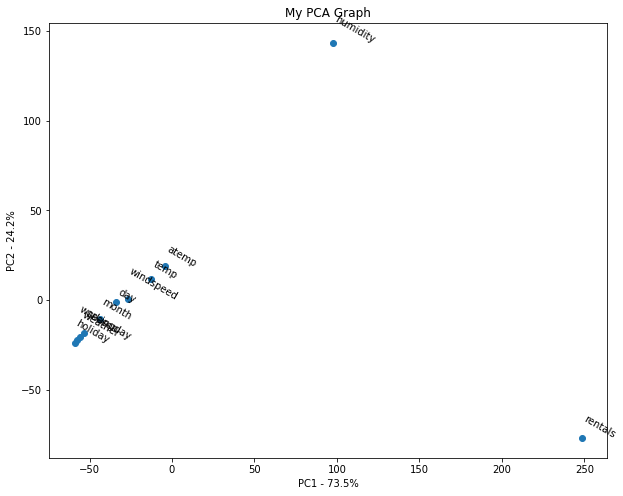

In [37]:
#########################
#
# Draw a scree plot and a PCA plot
#
#########################
 
#The following code constructs the Scree plot
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()
 
#the following code makes a fancy looking plot using PC1 and PC2
pca_df = pd.DataFrame(pca_data, index=df_relevant.drop(columns=['Year','hour']).columns, columns=labels)
 
plt.figure(figsize=(10,8))
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('My PCA Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
 
for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]),rotation=-30)
 
plt.show()

In [ ]:
pca.components_[0].shape

In [ ]:
pca_df